In [2]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#for live plotting
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

%run lipm_env.ipynb #imports LIPM Env

In [3]:
class Buffer:
    def __init__(self, buffer_size):
        
        self.buffer_size = buffer_size
        self.buffer = np.zeros((1, 2 + 1 + 1 + 2)) ## should be made variables
        
    def size(self):
        
        return len(self.buffer)
    
    def store(self, state, action, reward, next_state, done):
        ## stores new data in the buffer
        new_data = 9999*np.ones((1, 2 + 1 + 1 + 2))
        new_data[0, 0:2] = state
        new_data[0, 2:4] = [action, reward]
        if not done:
            new_data[0, 4:] = next_state 
        else:
            new_data[0, 4:] = [np.nan, np.nan]
        self.buffer = np.concatenate((self.buffer, np.around(new_data, 2)), axis = 0)
        
        #removes the first element if it is zero.
        if np.all(self.buffer[0] == 0):
            self.buffer = self.buffer[1:]
            
        # removes first element if the desired buffer size is obtained
        elif self.size() > self.buffer_size:
            self.buffer = self.buffer[1:]
            
    def sample(self, batch_size):
        # returns a random mini batch of desired batch size
        return np.asarray(random.sample(list(self.buffer), batch_size))

In [4]:
class NN(nn.Module):
    def __init__(self, inp_size, out_size):
        
        super(NN, self).__init__()
        self.l1 = nn.Linear(inp_size, 1024)
        self.l2 = nn.Linear(1024, 1024)
        self.l3 = nn.Linear(1024, out_size)
    
    def forward(self, x):
        
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        return x

In [5]:
class DQStepper:
    def __init__(self, no_actions = 9, lr = 1e-4, gamma = 0.9, use_tarnet = False):
        
        self.device = torch.device("cpu")
        self.dq_stepper = NN(3, 1).to(self.device) #state+ action -> q_value
        self.optimizer = torch.optim.SGD(self.dq_stepper.parameters(), lr)
        self.use_tarnet = use_tarnet
        if self.use_tarnet:
            self.dq_tar_stepper = NN(3, 1).to(self.device)
            self.dq_tar_stepper.load_state_dict(self.dq_stepper.state_dict())
            self.dq_tar_stepper.eval()
        self.gamma = gamma #discount factor
        self.no_actions = no_actions
                
    def predict_action_value(self, x):
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def tar_predict_action_value(self, x):
        # this function uses tar net to predict 
        # the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_tar_stepper(torch_x_in).detach().numpy()
        return np.argmin(q_values), q_values[np.argmin(q_values)]
    
    def predict_eps_greedy(self, x, eps = 0.1):
        # This function returns prediction based on epsillon greedy algorithm
        if np.random.random() > eps:
            return self.predict_action_value(x)[0]
        else:
            return np.random.randint(self.no_actions)
        
    def optimize(self, mini_batch, tau = 0.001):
        # This function performs one step of back propogation for the given mini_batch data
        x_in = torch.FloatTensor(mini_batch[:,0:3].copy(), device = self.device)
        y_train = torch.FloatTensor(mini_batch[:,3].copy(), device = self.device)
        for i in range(len(mini_batch)):
            if not np.isnan(mini_batch[i,4:]).all():
                if not self.use_tarnet:
                    y_train[i] += self.gamma * self.predict_action_value(mini_batch[i,4:])[1]
                else:
                    y_train[i] += self.gamma * self.tar_predict_action_value(mini_batch[i,4:])[1]

        y_train = y_train.unsqueeze(1).detach() #ensures that gradients are not computed on this
        x_train = self.dq_stepper(x_in)

        loss = F.mse_loss(x_train, y_train)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        if self.use_tarnet:
            for tar_param, param in zip(self.dq_tar_stepper.parameters(), self.dq_stepper.parameters()):
                tar_param.data.copy_(tar_param.data * (1.0 - tau) + param.data * tau)
                
        return loss
    
    def live_plot(self, history, figsize=(7,5), title='history'):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        for label,data in history.items():
            plt.plot(data, label=label)
        plt.title(title)
        plt.grid(True)
        plt.xlabel('episode')
        plt.legend(loc='top right') # the plot evolves to the right
        plt.show();
        
    def predict_q(self, x):
        #for debugging
        # this function predicts the q_value for different actions and returns action and min q value
        x_in = np.tile([x[0], x[1], 0], (self.no_actions, 1))
        x_in[:,2] = np.arange(self.no_actions)
        torch_x_in = torch.FloatTensor(x_in, device = self.device)
        with torch.no_grad():
            q_values = self.dq_stepper(torch_x_in).detach().numpy()
        return q_values

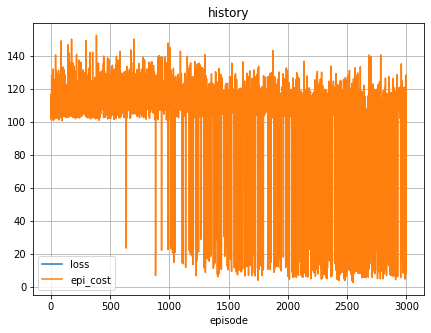

In [25]:
## This block is for training the dq stepper
buffer_size = 10000
buffer = Buffer(buffer_size)

dqs = DQStepper(lr=1e-4, gamma=0.98, use_tarnet= True)
batch_size = 16
epsillon = 0.2

e = 1
no_epi = 3000
no_steps = 10 ## number of steps simulated per episode (pendulum steps)
step_time = 0.1 ## time after which step is taken
env = LipmEnv(0.2, 0.22, [2, 2, 0])

history = {'loss':[], 'epi_cost':[]}
while e < no_epi:
    v_init = 6*(np.random.rand() - 0.5)
    state = env.reset_env([0.0, v_init], no_steps*step_time)
    if buffer.size() == buffer_size:
        history['epi_cost'].append(epi_cost)
#         history['loss'].append(loss)
        dqs.live_plot(history)
        e += 1
    epi_cost = 0
    for n in range(no_steps):
        action = dqs.predict_eps_greedy(state, epsillon)
        next_state, cost, done = env.step_env(action, step_time)
        buffer.store(state, action, cost, next_state, done)
        state = next_state
        
        if buffer.size() == buffer_size:
            ## optimizing DQN
            loss = dqs.optimize(buffer.sample(batch_size))            
            epi_cost += cost
        if done:
            break
        

In [41]:
# This block is to save the model
name = "dqs_1"
torch.save(dqs.dq_stepper.state_dict(), "../../models/" + name)

[[95.706   ]
 [82.9574  ]
 [72.0608  ]
 [61.593483]
 [50.042027]
 [38.623276]
 [35.890114]
 [39.044292]
 [52.64928 ]]


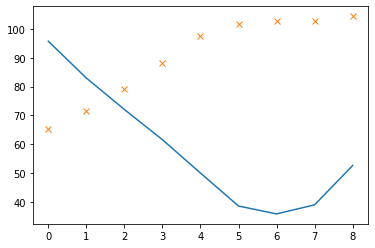

In [26]:
## visualising the q values
q_arr = []
q_arr.append(dqs.predict_q([0.0, 0.5]))
print(q_arr[0])

q_arr.append(dqs.predict_q([0, -1]))

plt.plot(q_arr[0])
plt.plot(q_arr[1], 'x')
plt.show()

In [39]:
state = env.reset_env([0.2, -1.0], no_steps*step_time)
epi_cost = 0
for n in range(no_steps):
    action, q_value = dqs.predict_action_value(state)
    print(action)
    next_state, cost, done = env.step_env(action, step_time)
    state = next_state
    epi_cost += cost
    if done:
        print(epi_cost)
        break
print("showing simulation...")  
env.show_episode(5, 1)

4
7
6
5
4
3
4
5
4
5
showing simulation...


<source type="video/mp4" src="data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA03W1kYXQAAAKuBgX//6rcRem9
5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIHIyODU0IGU5YTU5MDMgLSBILjI2NC9NUEVHLTQg
QVZDIGNvZGVjIC0gQ29weWxlZnQgMjAwMy0yMDE3IC0gaHR0cDovL3d3dy52aWRlb2xhbi5vcmcv
eDI2NC5odG1sIC0gb3B0aW9uczogY2FiYWM9MSByZWY9MyBkZWJsb2NrPTE6MDowIGFuYWx5c2U9
MHgzOjB4MTEzIG1lPWhleCBzdWJtZT03IHBzeT0xIHBzeV9yZD0xLjAwOjAuMDAgbWl4ZWRfcmVm
PTEgbWVfcmFuZ2U9MTYgY2hyb21hX21lPTEgdHJlbGxpcz0xIDh4OGRjdD0xIGNxbT0wIGRlYWR6
b25lPTIxLDExIGZhc3RfcHNraXA9MSBjaHJvbWFfcXBfb2Zmc2V0PS0yIHRocmVhZHM9OSBsb29r
YWhlYWRfdGhyZWFkcz0xIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFj
ZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJh
bWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdl
aWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MjUgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVz
aD0wIHJjX2xvb2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBx
cG1pbj0wIHFwbWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAAA2IZYiE
ADP//vbsvgU1/Z/QlxEsxdpKcD4qpICAdzTAAAADAAB5FfwSZP1ApEW79P7K1lNNnT6vMgJVzxNy
y1nh82fcNSFUxOoQoFhnJyjaUuOXFLagWDjyYfM6p+8B+CqrcppjRO8QCJeF9kpQkW/gVcD8AAAD
AQ9XfOogZfRlC1m5zMmAnjlZc74GH954uJqZOvMhYeTn3xxWJ6QAa9sSV9g1eGvQufVuXb7Zm6cj
L8y93qg+RZYiTiy9sSfk4YN4gq/LdI67lUN7euRZ7wSzXgsdf5SB6j4I7+qQ75xUzPuCKpXFayO8
5gJoiFE2i1+jZ4nSDtSZvlrmD6FJok5y71/AQOMZvalRe3KnSHOgIH+qqjEhUInBOHIK6gkp71HX
4Bb6VST7H3MurtzCoiPu4Awk2JHJNiGqY8Ni/Vb7Pjtz/gDPrQkNCRMbj9/6Q3elYKDknCD44v4M
07iLEJssqChAem1yVvnIw/odJw6ESExUq3FCbVjGphqlmrB1abMVTD39jXP3ypxC7MHpKUdYdTJA
B1tq2aoe2C0TImk1JynIzUVkNz9USImDQy6YU/1JqdPPXzWzQzwkB7oY0uzuIjCIfHi3TQ32wafp
+9ihpRjDoXhgnNx0yVUGlsLt6HvURZkknI/ZYo3ROhjdGufuAwdzqR9WauR4rXK/xm0shELyfdrc
Dq33oI6Kjvao63XwZDe3Py7nbwdT7Tnng3UAkoPWR1Pl9QL1CEKa9YwFsRPH4+DrX0m5BXTol/CE
oDoOQopP1oxwyhbNLodGrnrLOSISW1M5MW1Umiq2Iva+hQHo5JbnzPWfLNOcDOFArA6Y7vN8owUv
XgJsIS/r0MyRC2NWPP3RHNzmsnXmaW0bj0haSU733O/IMY+d8GARSmwv8n6Wg9N7bKJVeGMvbki4
AAADACg8x+nxuTCmd6YhRnQ45JOSk/XDlqFgBGklA8+/7wX9T1yo4TpUEHx828HsWe/fvHHhPgBW
ktopxqcV0H2Z2tslXNuVN45n/S45PYBS/hPbs5LRFdtdU8AprlqZGnnKgrAhRJiQDB+wqpDJdbpN
/xyYVQ5xdkH1MkoSnQyjufxvPWIZ8S+lIYgsbL6LvSHmiTFN1DzXnmBfRgqWxH83ZJgJRiA3DkBj
d8yD78h33jmHvuHEkX6eW4ultEN2G5l8MwMBWJ/JC+IJFBg2OxCVl4afLfZE7CMUDYoceCDJeMgr
bMOZ2b2fIkRoRevZfTF7yGa4yoJbpKeQd8eRJ7aMYPRr7SgELuxsFnvVsbEYg08C7WUm2uwiT12+
CxR0Bchg5nDbtBQ1m5g3iCL10R84v8wYfNATJn4vGr2IctgBJA4VQ0E75LfgzCzRy/qoVDm5ghC1
p+IlJkE9M2Vi0EEFaOMN0wv/hkfFPgS9Y1/K2JkKBiJvm2n263DA+d30c/jJnNv/MT24G/AzYqKd
5VMdIUvbNXlyFFOMyFG8XvHZYq1w8+/oUvVSKS7JGr3zX+m+Ss+lLljUdS9vCVGPa1yC4O3hqUtn
y+dbSUeDVdbK/npWpON7DfF4Mj6N4MTpN6aRRE7ZTQL4IoBtfnCXkUpB8xbCykZ8vn6I79MuYwnE
P7GTXIapor+R6yI8bQeZTGWE9wI6HdwxxKDXMe9gVLTBdQL2JuMhULZxCx+oIG4A6GhJ+66rVuZq
L+QNj8RSHcyPAEzg5uLJJQDJHVn5Y4PKk8ZX6xCq1Vkr0paajJ3J1j7SHG1cGa8ziFy8XmEimvBD
q2BjD2HZgL22Pcv95t0RXiPWPLzrKZCI+CySvTM9hvjf8RyhSlWc2zCk7jEiO3DU0oUgq/Gk1RNS
y+39RIrITqhwj6TWo0/itvQC3HQBbWGUKVPWHeEEdJpyWE6hzNX/WB+9o0VHU8Qv4GuRaQ7FbMmz
3Xc/Ka8AP8fKcOzo2xjc4GgXzPQXCq5pd3t7vErFN+OV6tF8ihgvN/yI+jl7m3VNxEbFveyng8gc
pjySRTdXU1dPsv5wuDuy8vBX5xK2xNwPw3NFvH+0W4nG7HUVuG9pPkPMVdhLk9QssR4Mtsk/znjc
3Qly6J5kBgWMasTLv6Rmnh+/EZrl6eWu0ZcP/WFyvUgQezK/tSJHxxlquGZbWVM5vOIY1EQdNpMR
C55002AvZWac+kVpKEln0Dr5N6xcxYpJcHhucD5fUuDkj+0KpE906LYPtIQ7J2K8sG26wCWXiea+
agBjT8D5NHcQuqb8oK5d/OyJWKaNUorwk8qapJIk5q6j7wnfUiB+hEZMuIiunWed9zr7rmOZGrsn
rxIKAPj20ZaXNROtW+2FlIBqsavKjjAzi1DmSSv4nmYUzxXDQU+AvgrGfDnXq33cWuT9eAeCPTz1
B0ZZDe7gQfM5+louSb5QxoBvR17fXWDGe1vTaaO+hfmi57mmhouoOD7aWT0J5OV/bQ5iX8C5qTuY
g6rBeAn712oJmtcm4mg8pWk44kXHe74iw9NVlaQCb8HVMa9ovGTdX6Ugy2B2avFiNhY7ELPu4Vuz
mwHwbMag93C2E5mVzWkbGM1I+VHP82fJAPe3ImgSJgmfOg2mjd0/nHMFz1RhCFr9nF5vbqoJEjy5
mR4QdgixeY8Wk2L+3cMboCwliWtojcRgQXu00NmEw+dLuJqadAsXh2/4S7UKBq6PbtSV+xQj8akt
Pi14S50lP54VWvz8ZOoL60WaiwAehvCyX1RWyAUMZbGJMgrFkje7McNq2S0O0RFDuXw/9JxprkDR
w/+kx8Md1ypO0aT+/gWOP4FXbYOTiE7w3YeOepmv9yMXYZkD2ex8UW6z4b5mbLr3M7QEYvaSB3Lo
ZMqCTsZICQ70CY6yKJGydaYVl145MVLnFs0XGWqkS9MfGcw0ivXcB4TckZUgC2IKHbz0VHRvGMHw
Czu5d2rNT17k5m1JOCAlp